In [36]:
import os
import json
import yaml
import random
import shutil
import numpy as np
import pandas as pd
from bagpy import bagreader
import seaborn as sns

import pickle
from numpy.lib.format import open_memmap

from feeder.feeder import Feeder
from torch.utils.data import DataLoader
from net.st_gcn import Model
import torch

from net.st_gcn import Model  # Ensure this is the correct import path for your model

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from scipy.spatial.transform import Rotation as R
from sklearn.model_selection import ParameterSampler

## **Hyperparameters**

In [2]:
# Define hyperparameters for the pipeline
Gesture_names = ["Waving_come", "Waving_leave", "Pointing", "Stop", "ODD"]  # List of gesture names

frames_length     = 30                                                      # Input frame length #00FF00
path_main         = './frame_30'
CUT_GAP           = 60
model_save_folder = 'st_gcn_model_30.pth'

# Training Parameters
training_config = {
    'random_choose': True,
    'random_move': True,
    'window_size': frames_length,
    'batch_size': 16,
    'test_batch_size': 16,
    # 'base_lr': 0.001,
    # 'step': [80],
    'num_epoch': 100,
    'device': [0],
    'num_class': 5,
    'in_channels': 3,
    'edge_importance_weighting': True,
    'layout': 'my_pose',
    'strategy': 'spatial'
}

rosbag_folder = "./rosbag"                                                  # Path to the folder containing rosbag videos
npy_output_folder = "./npy_output"                                          # Folder to save processed .npy files

os.makedirs(npy_output_folder, exist_ok=True)

---

## **Tune the model**

In [3]:
# Paths
train_data_path  = path_main + '/train_data.npy'
train_label_path = path_main + '/train_label.pkl'
val_data_path    = path_main + '/val_data.npy'
val_label_path   = path_main + '/val_label.pkl'


In [4]:
# Initialize Feeder instances for training and validation
train_feeder = Feeder(
    data_path=train_data_path,
    label_path=train_label_path,
    random_choose=training_config['random_choose'],
    random_move=training_config['random_move'],
    window_size=training_config['window_size']
)

val_feeder = Feeder(
    data_path=val_data_path,
    label_path=val_label_path,
    random_choose=False,
    random_move=False,
    window_size=training_config['window_size']
)


# Create DataLoaders
train_loader = DataLoader(train_feeder, batch_size=training_config['batch_size'], shuffle=True)
val_loader = DataLoader(val_feeder, batch_size=training_config['test_batch_size'], shuffle=False)

print(f"Train Loader: {len(train_loader)} batches")
print(f"Validation Loader: {len(val_loader)} batches")

Train Loader: 147 batches
Validation Loader: 21 batches


In [5]:

model = Model(
    in_channels=training_config['in_channels'],
    num_class=training_config['num_class'],
    edge_importance_weighting=training_config['edge_importance_weighting'],
    graph_args={
        'layout': training_config['layout'],
        'strategy': training_config['strategy']
    }
)
model = model.to(torch.device(f'cuda:{training_config["device"][0]}' if torch.cuda.is_available() else 'cpu'))

In [32]:
param_distributions = {
    "base_lr": np.logspace(-3, -1, 5),  
    "step": [70, 80, 90] 
}

In [33]:
def train_and_evaluate(model, train_loader, val_loader, base_lr, step, num_epoch=10):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=base_lr, momentum=0.9, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[step], gamma=0.1)
    criterion = torch.nn.CrossEntropyLoss()

    accuracies = []  

    for epoch in range(num_epoch):
        model.train()
        total_loss = 0

        for batch_data, batch_label in train_loader:
            batch_data, batch_label = batch_data.to(device), batch_label.to(device)
            optimizer.zero_grad()

            output = model(batch_data)
            loss = criterion(output, batch_label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        scheduler.step()

        
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_data, batch_label in val_loader:
                batch_data, batch_label = batch_data.to(device), batch_label.to(device)
                output = model(batch_data)
                correct += (torch.argmax(output, dim=1) == batch_label).sum().item()

        val_accuracy = correct / len(val_loader.dataset)
        accuracies.append(val_accuracy)
        # print(f"Epoch {epoch+1}: Val Accuracy: {val_accuracy:.4f}")

    mean_acc = np.mean(accuracies)
    return mean_acc

In [41]:
n_trials = 15
results = []
param_list = list(ParameterSampler(param_distributions, n_iter=n_trials, random_state=42))

for i, params in enumerate(param_list):
    print(f"Trial {i+1}/{n_trials}: {params}")
    model = Model(  # initialize model
        in_channels=training_config['in_channels'],
        num_class=training_config['num_class'],
        edge_importance_weighting=training_config['edge_importance_weighting'],
        graph_args={
            'layout': training_config['layout'],
            'strategy': training_config['strategy']
        }
    )
    model = model.to(torch.device(f'cuda:{training_config["device"][0]}' if torch.cuda.is_available() else 'cpu'))

    acc = train_and_evaluate(model, train_loader, val_loader, 
                             base_lr=params["base_lr"], step=params["step"],
                             num_epoch=training_config['num_epoch'])
    results.append((params, acc))
    print(f'Trial {i+1} accuracy: {acc}')

print("Hyperparameter tuning completed!")


best_params, best_acc = max(results, key=lambda x: x[1])
print(f"Best Parameters: {best_params}")
print(f"Best Validation Accuracy: {best_acc:.4f}")

Trial 1/15: {'step': 70, 'base_lr': np.float64(0.001)}
Trial 1 accuracy: 0.9315030674846625
Trial 2/15: {'step': 80, 'base_lr': np.float64(0.001)}
Trial 2 accuracy: 0.9339570552147239
Trial 3/15: {'step': 90, 'base_lr': np.float64(0.001)}
Trial 3 accuracy: 0.9339263803680982
Trial 4/15: {'step': 70, 'base_lr': np.float64(0.0031622776601683794)}
Trial 4 accuracy: 0.94
Trial 5/15: {'step': 80, 'base_lr': np.float64(0.0031622776601683794)}
Trial 5 accuracy: 0.9392944785276072
Trial 6/15: {'step': 90, 'base_lr': np.float64(0.0031622776601683794)}
Trial 6 accuracy: 0.9402760736196317
Trial 7/15: {'step': 70, 'base_lr': np.float64(0.01)}
Trial 7 accuracy: 0.9233435582822084
Trial 8/15: {'step': 80, 'base_lr': np.float64(0.01)}
Trial 8 accuracy: 0.926411042944785
Trial 9/15: {'step': 90, 'base_lr': np.float64(0.01)}
Trial 9 accuracy: 0.9283742331288343
Trial 10/15: {'step': 70, 'base_lr': np.float64(0.03162277660168379)}
Trial 10 accuracy: 0.8988343558282207
Trial 11/15: {'step': 80, 'base_lr

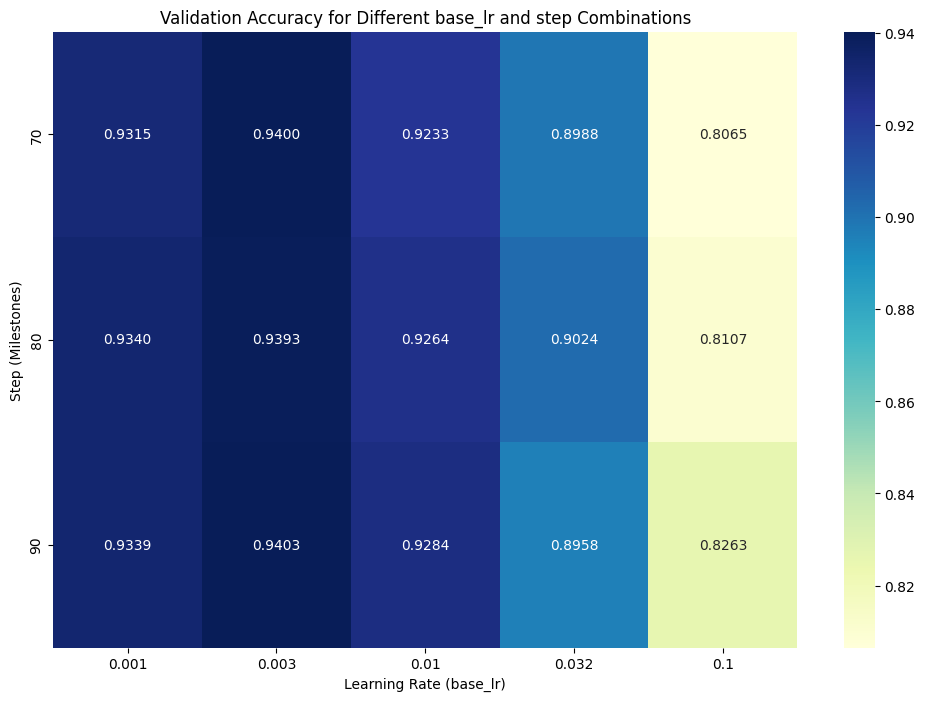

In [43]:
base_lrs = [round(result[0]["base_lr"], 3) for result in results]
steps = [result[0]["step"] for result in results]
accuracies = [result[1] for result in results]


data = pd.DataFrame({
    "base_lr": base_lrs,
    "step": steps,
    "accuracy": accuracies
})


heatmap_data = data.pivot_table(values="accuracy", index="step", columns="base_lr")

# Heatmap Plot
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".4f")

plt.title("Validation Accuracy for Different base_lr and step Combinations")
plt.xlabel("Learning Rate (base_lr)")
plt.ylabel("Step (Milestones)")
plt.show()
